<a href="https://colab.research.google.com/github/Nebius-Academy/LLM-Engineering-Essentials/blob/main/topic3/3.3_advanced_rag_components.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LLM Engineering Essentials by Nebius Academy

Course github: [link](https://github.com/Nebius-Academy/LLM-Engineering-Essentials/tree/main)

The course is in development now, with more materials coming soon.
Starting **May 7**, join weekly expert-led Q&A sessions to ask questions and get feedback from course lecturers and mentors.

[Sign up here](https://nebius.zoom.us/webinar/register/2017452395379/WN_fRQs-XofSzivwkNQUfGxBA) for the intro session — it's happening on May 7 at 7 PM CET.

# LLM Engineering Essentials 3.3. Advanced RAG components

In this notebook, we'll discuss:

* Two-stage RAG pipeline that augments retrieval with **reranking**
* **Graph databases** which allow to capture connections inside data better than vector stores do
* **Hierarchical Navigable Small World** (**HNSW**) which is the nearest neighbour search algorithm powering many of today's vector stores.

In [ ]:
!pip install -q openai

In [ ]:
import os

with open("nebius_api_key", "r") as file:
    nebius_api_key = file.read().strip()

os.environ["NEBIUS_API_KEY"] = nebius_api_key

# Two-stage retrieval, take 1: Reranking

RAG inherited the idea of two-step retrieval from web search and recommendations.

The problem with vector search is that, despite everything, distance between embeddings may fail to fully capture semantic similarity. Model-based relevance scorers might potentially perform better. At the same time, vector search boils down to computing scalar products of vectors, which is significantly cheaper than computing `score(query, database_entry`) for all entries of our database.

Inspired by these considerations, the following process is often uses:

1. Use cheap vector retrieval to get a large set of candidates (larger than we need)
2. Score these candidates with a model, which is a more powerful but at the same time more expensive scorer. These models are often known as **rerankers**.

<center>
<img src="https://drive.google.com/uc?export=view&id=1mrk83CENtZHTzkqEOBI-frCj4lo7sBSR" width=600 />

[Source](https://www.pinecone.io/learn/series/rag/rerankers/)

</center>

A popular reranker architecture are **cross encoders** - encoder-only transformers that take a concatenation of two sequences as an input and produce a relevance score

<center>
<img src="https://drive.google.com/uc?export=view&id=14SpSRIyyY_xfrxR4XHkIPitWj5zQTDKz" width=400 />

</center>

However, recently LLMs are also being used as rerankers.

As examples, we'll use two models from [Mixedbread](https://www.mixedbread.com/) which is a service providing RAG tools including a very good reranker model family.

The models we'll try are:

1. **mxbai-rerank-large-v1** ([its page on Hugging Face](https://huggingface.co/mixedbread-ai/mxbai-rerank-large-v1)), which is a 435M-size cross-encoder model with context length of 512 tokens - small enough for quick experimentation.

  See more details in Mixedbread's [blog post](https://www.mixedbread.com/blog/mxbai-rerank-v1).

2. **mxbai-rerank-base-v2** ([its page on Hugging Face](https://huggingface.co/mixedbread-ai/mxbai-rerank-base-v2)), which is an LLM fine tuned from **Qwen-2.5-0.5B**.

  The **mxbai-rerank-base-v2** model and its larger counterpart **mxbai-rerank-large-v2** are also interesting due to their training methodology. The authors took the 0.5B and 1.5B version of **Qwen-2.5** as a base model and used a three-stage training process which is quite characteristic for Q1 2025:

  ![](https://www.mixedbread.com/_next/image?url=%2F_next%2Fstatic%2Fmedia%2Ftraining-methodology.be8e6c37.png&w=1920&q=75&dpl=dpl_7psJGN4mGSVvEewvaP5Y3yiVRQmP)

  [Source](https://www.mixedbread.com/blog/mxbai-rerank-v2)

  See more details in [their blog post](https://www.mixedbread.com/blog/mxbai-rerank-v2).

Due to their small size, these models may be used on CPU, though we'd recommend using GPU for **mxbai-rerank-base-v2**.

**Trying mxbai-rerank-base-v1**

For this simple demonstration, we created 7 documents - some of them tell about the effect of the Elixir of Umbral Sight, while others are here to confuse the reranker. All o them might be fetched by vector search.

In [ ]:
from sentence_transformers import CrossEncoder

# Load the model
reranker_model = CrossEncoder("mixedbread-ai/mxbai-rerank-base-v1")

# Example query and documents
query = "What does the Elixir of Umbral Sight do?"

documents = [
    "The Elixir of Umbral Sight grants the drinker flawless vision in all forms of darkness, both magical and mundane, lasting up to one hour. Popular among night-stalkers and shadow scouts.",
    "Though rare, the Elixir of Umbral Sight can sometimes be found in alchemical markets of the Shrouded Coast, where a single vial may cost up to 300 silver pieces due to demand from adventuring parties.",
    "The Elixir of Moon's Grace, often confused with Umbral Sight, enhances low-light vision and heightens balance, but does not function in magical darkness.",
    "An old bard’s tale claims that the Elixir of Umbral Sight reveals not only darkness, but truth — though most scholars dismiss this as poetic exaggeration.",
    "The Elixir of Umbral Sight is said to grant sight in total darkness, though the exact duration varies. Some claim it fades faster if the user is afraid.",
    "The Elixir of Wyrm's Breath allows temporary fire-breathing and heat resistance. Its reddish hue and wax-sealed vials are commonly mistaken for Umbral Sight in low lighting.",
    "Potions brewed from deep mushroom spores often glow faintly, and while they lack any magical effect, they are sometimes used by smugglers for light in underground tunnels."
]

# Rank results
results = reranker_model.rank(query, documents, return_documents=True, top_k=4)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/967 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/369M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.45k [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/8.65M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/23.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/970 [00:00<?, ?B/s]

In [ ]:
results

[{'corpus_id': 0,
  'score': np.float32(0.98551756),
  'text': 'The Elixir of Umbral Sight grants the drinker flawless vision in all forms of darkness, both magical and mundane, lasting up to one hour. Popular among night-stalkers and shadow scouts.'},
 {'corpus_id': 4,
  'score': np.float32(0.971307),
  'text': 'The Elixir of Umbral Sight is said to grant sight in total darkness, though the exact duration varies. Some claim it fades faster if the user is afraid.'},
 {'corpus_id': 3,
  'score': np.float32(0.82615745),
  'text': 'An old bard’s tale claims that the Elixir of Umbral Sight reveals not only darkness, but truth — though most scholars dismiss this as poetic exaggeration.'},
 {'corpus_id': 2,
  'score': np.float32(0.3823795),
  'text': "The Elixir of Moon's Grace, often confused with Umbral Sight, enhances low-light vision and heightens balance, but does not function in magical darkness."}]

**Trying mxbai-rerank-base-v2**

In [ ]:
# This might require you to restart a session
!pip install -q mxbai-rerank

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 131.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 104.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 46.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 21.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 108.3 MB/s eta 0:00:00


In [ ]:
from mxbai_rerank import MxbaiRerankV2

reranker_model = MxbaiRerankV2("mixedbread-ai/mxbai-rerank-base-v2")

# Example query and documents
query = "What does the Elixir of Umbral Sight do?"

documents = [
    "The Elixir of Umbral Sight grants the drinker flawless vision in all forms of darkness, both magical and mundane, lasting up to one hour. Popular among night-stalkers and shadow scouts.",
    "Though rare, the Elixir of Umbral Sight can sometimes be found in alchemical markets of the Shrouded Coast, where a single vial may cost up to 300 silver pieces due to demand from adventuring parties.",
    "The Elixir of Moon's Grace, often confused with Umbral Sight, enhances low-light vision and heightens balance, but does not function in magical darkness.",
    "An old bard’s tale claims that the Elixir of Umbral Sight reveals not only darkness, but truth — though most scholars dismiss this as poetic exaggeration.",
    "The Elixir of Umbral Sight is said to grant sight in total darkness, though the exact duration varies. Some claim it fades faster if the user is afraid.",
    "The Elixir of Wyrm's Breath allows temporary fire-breathing and heat resistance. Its reddish hue and wax-sealed vials are commonly mistaken for Umbral Sight in low lighting.",
    "Potions brewed from deep mushroom spores often glow faintly, and while they lack any magical effect, they are sometimes used by smugglers for light in underground tunnels."
]

# Lets get the scores
results = reranker_model.rank(query, documents, return_documents=True, top_k=4)

print(results)


config.json:   0%|          | 0.00/740 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/988M [00:00<?, ?B/s]

Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.


generation_config.json:   0%|          | 0.00/242 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/7.34k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/605 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/613 [00:00<?, ?B/s]

You're using a Qwen2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:2718: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


[RankResult(index=0, score=10.889143943786621, document='The Elixir of Umbral Sight grants the drinker flawless vision in all forms of darkness, both magical and mundane, lasting up to one hour. Popular among night-stalkers and shadow scouts.'), RankResult(index=3, score=10.011771202087402, document='An old bard’s tale claims that the Elixir of Umbral Sight reveals not only darkness, but truth — though most scholars dismiss this as poetic exaggeration.'), RankResult(index=4, score=9.784040451049805, document='The Elixir of Umbral Sight is said to grant sight in total darkness, though the exact duration varies. Some claim it fades faster if the user is afraid.')]


In [ ]:
results

[RankResult(index=0, score=10.889143943786621, document='The Elixir of Umbral Sight grants the drinker flawless vision in all forms of darkness, both magical and mundane, lasting up to one hour. Popular among night-stalkers and shadow scouts.'),
 RankResult(index=3, score=10.011771202087402, document='An old bard’s tale claims that the Elixir of Umbral Sight reveals not only darkness, but truth — though most scholars dismiss this as poetic exaggeration.'),
 RankResult(index=4, score=9.784040451049805, document='The Elixir of Umbral Sight is said to grant sight in total darkness, though the exact duration varies. Some claim it fades faster if the user is afraid.'),
 RankResult(index=2, score=8.810643196105957, document="The Elixir of Moon's Grace, often confused with Umbral Sight, enhances low-light vision and heightens balance, but does not function in magical darkness.")]

Note that **v1** and **v2** output scores of different scale.

Adding a reranking stage to a RAG pipeline is quite straightforward, and this will be one of your practical tasks in this lesson.

# Graph databases

Vector store are great to encode abstract semantic similarity, but their accuracy in retrieving facts and connections may be mediocre. So, in some cases it's better to check other database types.

**Graph databases** typically store **knowledge graphs** which contain

* **nodes** which are intities of interest to you - in the example below these are people, organizations, and documents
* **relations** between nodes - in the example below these are "[*person*] works at [*organization*]", "[*person*] is spouse of [*person*]", and "[*person*] is mentioned in [*document*]"

<center>
<img src="https://drive.google.com/uc?export=view&id=1m9uIJ4Avbr-mrOoZ-tOl0MHql89_TV-H" width=500 />

</center>

There is a number of particular implementations of graph databases. We'll try [**Neo4j**](https://neo4j.com/).

## Getting started with Neo4j

First of all, you'll need to registed and get a password. To do this, please go to https://neo4j.com/ and press *Get started for free*. After a simple registration procedure, you'll eventually obtain a **.txt** file with credentials that will likely be formatted as

```
# Wait 60 seconds before connecting using these details, or login to https://console.neo4j.io to validate the Aura Instance is available
NEO4J_URI=<your_uri>
NEO4J_USERNAME=<your_username>
NEO4J_PASSWORD=<your_password>
AURA_INSTANCEID=<your_instance_id>
AURA_INSTANCENAME=<your_instance_name>
```

The following code will, parse such a file, save all the credentials as environmental variables, and initialize connection with your database.

In [1]:
!pip install --upgrade --quiet  langchain langchain-neo4j langchain-openai langchain-huggingface langchain-experimental neo4j
!pip install -q lancedb pyarrow tiktoken
!pip install -qU langchain-text-splitters
!pip install -q openai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.4/62.4 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.2/209.2 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 312.3/312.3 kB 20.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 56.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 433.9/433.9 kB 29.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 171.3/171.3 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 56.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.3/302.3 kB 20.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 103.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2

In [2]:
def parse_neo4j_config(file_path='neo4j_credentials.txt'):
    """
    Parse a Neo4j Aura configuration file and extract connection details.

    Args:
        file_path (str): Path to the configuration file

    Returns:
        dict: Dictionary containing the parsed connection details
    """
    config = {}

    try:
        with open(file_path, 'r') as file:
            for line in file:
                # Skip comments and empty lines
                line = line.strip()
                if not line or line.startswith('#'):
                    continue

                # Parse key-value pairs
                if '=' in line:
                    key, value = line.split('=', 1)
                    config[key] = value

        return config

    except FileNotFoundError:
        print(f"Error: File '{file_path}' not found.")
        return None
    except Exception as e:
        print(f"Error parsing file: {str(e)}")
        return None

config = parse_neo4j_config()

import os

from langchain_neo4j import Neo4jGraph

os.environ["NEO4J_URI"] = config["NEO4J_URI"]
os.environ["NEO4J_USERNAME"] = config["NEO4J_USERNAME"]
os.environ["NEO4J_PASSWORD"] = config["NEO4J_PASSWORD"]

graph = Neo4jGraph(refresh_schema=False)

The `graph` is the connection to the Neo4j database.

Now, we'll also need our Nebius AI Studio credentials:

In [3]:
with open("nebius_api_key", "r") as file:
    nebius_api_key = file.read().strip()

os.environ["NEBIUS_API_KEY"] = nebius_api_key

## Exploring a simple graph database

I asked ChatGPT to generate a short story for us to play with:

In [4]:
story = """Virenthia is one of the Five Eastern Realms, bordered by Caldrien to the west and Eshkar to the south. Since the War of Withering (1023 AE), it has been ruled by the House of Halveric, a noble dynasty claiming descent from the Moonbound Kings of old.

The current monarch of Virenthia, Queen Aeryn Halveric, ascended the throne in 1127 AE following the death of her father, King Thandor Halveric, who ruled for nearly three decades.

Virenthia maintains tense diplomatic ties with Eshkar, which has long disputed the control over the border town of Dunmire. In contrast, Virenthia is allied with Caldrien, bound by the marriage pact between Aeryn’s cousin Lord Caelum Halveric and Lady Virelle of Caldrien.

Queen Aeryn has named Princess Elira Halveric, her younger sister, as heir presumptive of Virenthia, as she remains unmarried and without children."""

We'll create a database capturing

* Entities of type `PERSON` and `COUNTRY`
* Relationships `RULER_OF`, `NEIGHBOUR_OF` (between countries), and `MENTIONED_IN` (a particular sentence).

But how to extract these relations? We could probably do it with rules, but that's not fun! Instead, we'll use LLMs! We can even need to bother with prompts: the **Langchain** library has all the infrastructure; we only need to name the relations and hope that the LLM is powerful enough to understand what we need from it. We'll use **Llama-3.1-70B** served by Nebius AI Studio.

In [5]:
from langchain_experimental.graph_transformers import LLMGraphTransformer
from langchain_openai import ChatOpenAI
from langchain_core.documents import Document
from langchain_core.prompts.chat import ChatPromptTemplate

# This defines the LLM:
llm = ChatOpenAI(
    base_url="https://api.studio.nebius.ai/v1/",
    api_key=os.environ.get("NEBIUS_API_KEY"),
    temperature=0,
    model_name="meta-llama/Meta-Llama-3.1-70B-Instruct")

llm_transformer = LLMGraphTransformer(
    llm=llm,
    allowed_nodes=["Character", "Country"],
    allowed_relationships=[
        ("Character","CHARACTER_IS_RULER_OF","Country"),
        ("Character","IS_HEIR_OF","Character"),
        ("Country","COUNTRY_IS_NEIGHBOUR_TO","Country")
    ],
    node_properties=["ruler:reign_start_year"],
    strict_mode=True
)

Now, the **LLMGraphTransformer** will (hopefully) find all the required relations and properties.

In [6]:
documents = [Document(page_content=sentence) for sentence in story.split("\n")]
graph_documents = llm_transformer.convert_to_graph_documents(documents)
print(f"Nodes:{graph_documents[0].nodes}")
print(f"Relationships:{graph_documents[0].relationships}")

Nodes:[Node(id='Virenthia', type='Country', properties={'ruler:reign_start_year': '1023 AE'}), Node(id='Caldrien', type='Country', properties={}), Node(id='Eshkar', type='Country', properties={}), Node(id='House Of Halveric', type='Character', properties={})]
Relationships:[Relationship(source=Node(id='Virenthia', type='Country', properties={}), target=Node(id='Caldrien', type='Country', properties={}), type='COUNTRY_IS_NEIGHBOUR_TO', properties={}), Relationship(source=Node(id='Virenthia', type='Country', properties={}), target=Node(id='Eshkar', type='Country', properties={}), type='COUNTRY_IS_NEIGHBOUR_TO', properties={}), Relationship(source=Node(id='House Of Halveric', type='Character', properties={}), target=Node(id='Virenthia', type='Country', properties={}), type='CHARACTER_IS_RULER_OF', properties={})]


Now, we're ready to populate the actual database, which is accessible through the `graph` endpoint. With the `include_source=True` option toggled, the documents themselves (i.e. the sentences) will also be present in the database with ``

In [8]:
graph.add_graph_documents(graph_documents, include_source=True)

You can now explore your database in the Neo4j visual console: https://console-preview.neo4j.io/tools/explore or try some queries in the "query" pane. Just keep in mind that 1-2 minutes may pass before the data is updated on the web side.

You'll be able to see something like this:

<center>
<img src="https://drive.google.com/uc?export=view&id=1XEXEQk-qMnxbPCxLfRm0KZYYNw98HBuC" width=800 />

</center>

The extraction isn't flawless, but still it's a nice start.

Then return here to try some queries by API.

In [9]:
graph.query("MATCH (n) RETURN n LIMIT 10")

[{'n': {'id': 'Eshkar'}},
 {'n': {'id': 'House Of Halveric'}},
 {'n': {'id': 'd41d8cd98f00b204e9800998ecf8427e', 'text': ''}},
 {'n': {'id': '487d0d81733c094a928c4ac3f3c73282',
   'text': 'The current monarch of Virenthia, Queen Aeryn Halveric, ascended the throne in 1127 AE following the death of her father, King Thandor Halveric, who ruled for nearly three decades.'}},
 {'n': {'id': 'Queen Aeryn Halveric', 'ruler:reign_start_year': '1127 AE'}},
 {'n': {'id': 'King Thandor Halveric'}},
 {'n': {'id': '099ebf45d280504e42bdb5ed442caa3c',
   'text': 'Virenthia maintains tense diplomatic ties with Eshkar, which has long disputed the control over the border town of Dunmire. In contrast, Virenthia is allied with Caldrien, bound by the marriage pact between Aeryn’s cousin Lord Caelum Halveric and Lady Virelle of Caldrien.'}},
 {'n': {'id': 'Dunmire'}},
 {'n': {'id': 'Aeryn'}},
 {'n': {'id': 'Lord Caelum Halveric'}}]

## RAG with a graph database

Now that we have a database describing characters, countries, and relationships between them, we can let an LLM use it to answer questions like "Who rules Virenthia?"

For that, we're rely on the `GraphCypherQAChain` class from the `langchain_neo4j` library.

First of all, we'll refresh the schema to be sure that the `graph` endpoint has up-to-date understanding of the node and connection types.

In [15]:
graph.refresh_schema()

Now, let's define the `GraphCypherQAChain` that will wrap all the process for us. Under the hood, three stages will be performed:

* The LLM will formulate a query to the graph database using the prompts that Langchain and Neo4j provided
* The graph database will run the query, (hopefully) fetching some data
* The LLM will formulate the final answer

In [23]:
from langchain_neo4j.chains.graph_qa.cypher import GraphCypherQAChain

qa_llm = ChatOpenAI(
    base_url="https://api.studio.nebius.ai/v1/",
    api_key=os.environ.get("NEBIUS_API_KEY"),
    temperature=0,
    model_name="meta-llama/Meta-Llama-3.1-70B-Instruct")

chain = GraphCypherQAChain.from_llm(
    llm=qa_llm, graph=graph, verbose=True,
    allow_dangerous_requests=True # I love this one
)

It can be useful to check that the `chain` has correct understanding of node and relation types. They should be just as in the graph database:

In [24]:
print(chain.graph_schema)

Node properties:
Document {id: STRING, text: STRING}
Country {id: STRING, ruler:reign_start_year: STRING}
Character {id: STRING, ruler:reign_start_year: STRING}
Relationship properties:

The relationships:
(:Document)-[:MENTIONS]->(:Character)
(:Document)-[:MENTIONS]->(:Country)
(:Country)-[:COUNTRY_IS_NEIGHBOUR_TO]->(:Country)
(:Character)-[:CHARACTER_IS_RULER_OF]->(:Country)
(:Character)-[:IS_HEIR_OF]->(:Character)


In [25]:
chain.invoke("""
Who rules Virenthia?
""")



> Entering new GraphCypherQAChain chain...
Generated Cypher:
MATCH (c:Character)-[:CHARACTER_IS_RULER_OF]->(co:Country {id: "Virenthia"}) RETURN c.id
Full Context:
[{'c.id': 'House Of Halveric'}, {'c.id': 'Queen Aeryn Halveric'}, {'c.id': 'Queen Aeryn'}]

> Finished chain.


{'query': '\nWho rules Virenthia?\n',
 'result': 'Queen Aeryn Halveric rules Virenthia.'}

Note that if you choose an inferior LLM, it may fail to cope with creating the right query. In the example below, Llama-3.1-8B confuses the direction of the `CHARACTER_IS_RULER_OF` relation: instead of

```
(c:Character)-[:CHARACTER_IS_RULER_OF]->(co:Country {id: "Virenthia"})
```

it suggests

```
(c:Country {id: "Virenthia"})-[:CHARACTER_IS_RULER_OF]->(r:Character)
```

In [29]:
weak_qa_llm = ChatOpenAI(
    base_url="https://api.studio.nebius.ai/v1/",
    api_key=os.environ.get("NEBIUS_API_KEY"),
    temperature=0,
    model_name="meta-llama/Meta-Llama-3.1-8B-Instruct")

weak_chain = GraphCypherQAChain.from_llm(
    llm=weak_qa_llm, graph=graph, verbose=True,
    allow_dangerous_requests=True # I love this one
)

weak_chain.invoke("""
Who rules Virenthia?
""")



> Entering new GraphCypherQAChain chain...
Generated Cypher:
MATCH (c:Country {id: "Virenthia"})-[:CHARACTER_IS_RULER_OF]->(r:Character) RETURN r
Full Context:
[]

> Finished chain.


{'query': '\nWho rules Virenthia?\n', 'result': "I don't know the answer."}

## Clearing the traces of our activity from the Neo4j instance

Finishing working with the graph database, we'll clear it from out Neo4j instance.

In [25]:
graph.query("MATCH (n) DETACH DELETE n")

[]

# Two-stage retrieval, take 2: Combining the power of Vector and Graph Databases

Vector and graph databases have their own pros and cons:

* **Vector stores** are great at establishing *implicit*, topic-level connections between text fragments. For example, vector search draw parallels between discussions of web search and database retrieval.
* **Graph databases** capture *explicit* connections between particular entities. For example, it can encapsulate the fact that LanceDB is a vector store.

In this, they complement each other perfectly. Thus, adopting both database types in a RAG system may be very beneficial. The two-stage retrieval we'll discuss here is probably the most popular way of combining them.

The idea is the following:

* On **Stage 1**, a **vector store** is queried, returning several <font color='blue'>documents</font> (<font color='blue'>Doc1</font>, <font color='blue'>Doc2</font>, and <font color='blue'>Doc 3</font> on the image below)
* On **Stage 2**, from each of the stage 1 <font color='blue'>documents</font> we make several hops along the **graph database** edges - starting from `MENTIONS` arrows, we get to

  - *entities* mentioned in these docs
  - and then to other <font color='lightblue'>documents</font> mentioning these *entities*
  - and then to yet other *entities* connected to the initial *entities*.

  Like in the example below in two hops we reach <font color='lightblue'>Doc4</font>, <font color='green'>Person1</font>, <font color='green'>Person2</font>, <font color='orange'>Org1</font>, and <font color='orange'>Org2</font>.

  With Stage 2, we can significantly expand the retrieval's outreach, bringing both new documents and meaningful connections.


<center>
<img src="https://drive.google.com/uc?export=view&id=1G2B12OMz39uPmYVIprqi4f2SPyyP1z9h" width=600 />

</center>

Let's code this!

Basically, we have all the ingredients: both **LanceDB** as a vector store and **Neo4j** as a graph database. A tricky thing will be to ensure that documents have same ids in both LanceDB and Neo4j - so that we cound connect them between stages.

We'll experiment with a slightly larger story.

<details>
<summary>How we came up with this story</summary>

The story isn't entirely fiction. We took info from wiki pages of several rulers of VII century England and Wales - [Penda of Mercia](https://en.wikipedia.org/wiki/Penda_of_Mercia), [Edwin of Nortumbria](https://en.wikipedia.org/wiki/Edwin_of_Northumbria), [Oswald of Northumbria](https://en.wikipedia.org/wiki/Oswald_of_Northumbria), [Eanflæd](https://en.wikipedia.org/wiki/Eanfl%C3%A6d) and several more of their contemporaries. Then we thoroughly renamed the characters and the kingdoms and asked GPT-4.5 to weave everything into a single story. VII century is an exciting period of time, but not very well known, so we hope that LLMs wouldn't see through our disguise.

</details>

In [159]:
!wget https://github.com/Nebius-Academy/LLM-Engineering-Essentials/raw/main/topic3/northelm.txt -O northelm.txt

--2025-04-21 23:07:32--  https://github.com/Nebius-Academy/LLM-Engineering-Essentials/raw/main/topic3/northelm.txt
Resolving github.com (github.com)... 20.27.177.113
Connecting to github.com (github.com)|20.27.177.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Nebius-Academy/LLM-Engineering-Essentials/main/topic3/northelm.txt [following]
--2025-04-21 23:07:32--  https://raw.githubusercontent.com/Nebius-Academy/LLM-Engineering-Essentials/main/topic3/northelm.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6670 (6.5K) [text/plain]
Saving to: ‘northelm.txt’

northelm.txt        100%[===================>]   6.51K  --.-KB/s    in 0s      

2025-04-21 23:07:33 (63.8 MB/s) - ‘northelm.txt’ sa

In [163]:
with open("northelm.txt", "r") as f:
    story = "".join(f.readlines())

For your convenience we'll repeat the installation code here as well as reload the credentials:

In [165]:
!pip install --upgrade --quiet  langchain langchain-neo4j langchain-openai langchain-huggingface langchain-experimental neo4j
!pip install -q lancedb pyarrow tiktoken
!pip install -qU langchain-text-splitters
!pip install -q openai

In [166]:
import os
import uuid
from neo4j import GraphDatabase, basic_auth
import lancedb
from lancedb.pydantic import LanceModel, Vector
from lancedb.embeddings import get_registry
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_core.documents import Document
from langchain_neo4j import Neo4jGraph

In [167]:
# Setting your credentials

with open("nebius_api_key", "r") as file:
    nebius_api_key = file.read().strip()

os.environ["NEBIUS_API_KEY"] = nebius_api_key

def parse_neo4j_config(file_path='neo4j_credentials.txt'):
    """
    Parse a Neo4j Aura configuration file and extract connection details.

    Args:
        file_path (str): Path to the configuration file

    Returns:
        dict: Dictionary containing the parsed connection details
    """
    config = {}

    try:
        with open(file_path, 'r') as file:
            for line in file:
                # Skip comments and empty lines
                line = line.strip()
                if not line or line.startswith('#'):
                    continue

                # Parse key-value pairs
                if '=' in line:
                    key, value = line.split('=', 1)
                    config[key] = value

        return config

    except FileNotFoundError:
        print(f"Error: File '{file_path}' not found.")
        return None
    except Exception as e:
        print(f"Error parsing file: {str(e)}")
        return None

# Change the file name if you need
config = parse_neo4j_config(file_path='neo4j_credentials.txt')

os.environ["NEO4J_URI"] = config["NEO4J_URI"]
os.environ["NEO4J_USERNAME"] = config["NEO4J_USERNAME"]
os.environ["NEO4J_PASSWORD"] = config["NEO4J_PASSWORD"]

Here we load our story to LanceDB. Note the `chunk_id` field in the `FantasySchema` - they will mirror document ids in the graph database.

In [168]:
!rm -rf /tmp/lancedb
db = lancedb.connect("/tmp/lancedb")

embed_func = get_registry().get("huggingface").create(name="BAAI/bge-small-en-v1.5")


class FantasySchema(LanceModel):
    '''
    This is how we store data in the database.
    We need to have a vector here, but apart from this, we may have many other fields
    '''
    text: str = embed_func.SourceField()
    vector: Vector(embed_func.ndims()) = embed_func.VectorField(default=None)
    chunk_id: str

lance_table = db.create_table(
    "fantasy_world",
    mode='overwrite',
    schema=FantasySchema
)

# Split your documents and assign IDs
text_splitter = RecursiveCharacterTextSplitter(
    separators=["\n\n", "\n", ".", " "],
    chunk_size=512,
    chunk_overlap=64,
    length_function=len,
    is_separator_regex=False,
)

splitted = []
# We have only one story:
texts = [story]
for text in texts:
    docs = text_splitter.create_documents([text])
    for doc in docs:
        cid = str(uuid.uuid4())
        splitted.append({"text": doc.page_content, "chunk_id": cid})

# Ingest into LanceDB
lance_table.add(splitted, on_bad_vectors="drop")

Now, let's populate the graph database. Here, we'll store chunk ids in the metadata of each document as the `id` field.

In [191]:
from langchain_experimental.graph_transformers import LLMGraphTransformer
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(
    base_url="https://api.studio.nebius.ai/v1/",
    api_key=os.environ["NEBIUS_API_KEY"],
    model_name="meta-llama/Llama-3.3-70B-Instruct",
    temperature=0
)

llm_transformer = LLMGraphTransformer(
    llm=llm,
    allowed_nodes=["Character", "Country"],
    allowed_relationships=[
        ("Character", "CHARACTER_IS_RULER_OF", "Country"),
        ("Character", "IS_HEIR_OF", "Character"),
        ("Country", "COUNTRY_IS_NEIGHBOUR_TO", "Country")
    ],
    strict_mode=True
)

documents = [
    Document(
        page_content=row["text"],
        metadata={
            "id": row["chunk_id"]    # This are the same ids as in the vector store
        }
    )
    for row in splitted
]

# This may take some time: the LLM will process each document
graph_documents = llm_transformer.convert_to_graph_documents(documents)

In [192]:
# Connecting to your Neo4j endpoint
graph = Neo4jGraph(refresh_schema=False)

# Run this query if you want to get rid of previous databases
# that may still persist in your Neoj instance
graph.query("MATCH (n) DETACH DELETE n")

[]

In [193]:
graph.add_graph_documents(
    graph_documents,
    include_source=True,    # uses metadata['id'] for MERGE
    baseEntityLabel=True    # adds __Entity__ for performance
)

Let's double check that our text chunks got the same ids in both LanceDB and Neo4j.

In [197]:
for doc in documents[:8]:
    print(doc.metadata['id'], doc.page_content)

3509069f-e911-4f1b-9211-8ca1c154765a 1. The Rise of Aelfric the Uniter
19c8aaeb-5749-46f8-b9f2-7a314e92c731 In the waning years of the 6th century, Aelfric, a fierce and ambitious warlord, seized control over the divided kingdoms of Beranhold and Deyrmoor, neighbouring realms whose rivalry had long fragmented the region. Through a series of decisive battles, most notably at the River Idle, he established himself as the first High King of Northelm. Known for his unyielding approach to warfare, Aelfric subdued rebellious nobles and fortified his dominion, marking the beginning of Northelm’s ascension to prominence
4a85bfc9-c3b4-4bb3-af96-a30810e44801 . His conquest culminated in the infamous Battle of Chesterspire, where he defeated a coalition of native lords, effectively diminishing their influence in the northern realms. His rule, however, was cut short by betrayal and bloodshed, paving the way for a period of upheaval. Aelfric’s legacy remained, however, as his descendants would recl

In [195]:
graph.query("""MATCH (d:Document)
RETURN d.id, d.text
LIMIT 5""")

[{'d.id': '19c8aaeb-5749-46f8-b9f2-7a314e92c731',
  'd.text': 'In the waning years of the 6th century, Aelfric, a fierce and ambitious warlord, seized control over the divided kingdoms of Beranhold and Deyrmoor, neighbouring realms whose rivalry had long fragmented the region. Through a series of decisive battles, most notably at the River Idle, he established himself as the first High King of Northelm. Known for his unyielding approach to warfare, Aelfric subdued rebellious nobles and fortified his dominion, marking the beginning of Northelm’s ascension to prominence'},
 {'d.id': '4a85bfc9-c3b4-4bb3-af96-a30810e44801',
  'd.text': '. His conquest culminated in the infamous Battle of Chesterspire, where he defeated a coalition of native lords, effectively diminishing their influence in the northern realms. His rule, however, was cut short by betrayal and bloodshed, paving the way for a period of upheaval. Aelfric’s legacy remained, however, as his descendants would reclaim his dream of

Now, let's create a function performing two-stage retrieval:

In [198]:
from typing import List, Any, Dict

def two_stage_rag(
    query: str,
    lance_table=None,
    graph=None,
    lance_schema=None,
    max_results: int = 5, # Max documents fetched by vector search
    hop_min: int = 1,
    hop_max: int = 2,
    limit: int = 8, # For hom many documents to seach for paths in the graph
    max_paths: int = 8 # Max number of paths to return for each document
) -> Dict[str, Any]:
    """
    Perform two-stage retrieval using both vector and graph databases.

    Args:
        query: The user's query
        lance_table: LanceDB table
        graph: Neo4j graph instance
        max_results: Maximum number of vector results to retrieve
        hop_min: Minimum number of hops in graph traversal
        hop_max: Maximum number of hops in graph traversal
        limit: A confusing parameter actually telling

    Returns:
        Dictionary containing query, vector hits, and graph results
    """
    try:
        # Stage 1: retrieval in LanceDB
        docs = lance_table.search(query).limit(max_results).to_pydantic(lance_schema)
        chunk_ids = [d.chunk_id for d in docs]  # extract bridge keys

        # Stage 2: retrieval in Neo4j
        rows = graph.query(
            f"""
MATCH (d:Document) WHERE d.id IN $ids
OPTIONAL MATCH path=(d)-[*{hop_min}..{hop_max}]-(e)
WITH d, COLLECT(path)[0..$maxPaths] AS limitedPaths
RETURN
  d.id   AS cid,
  d.text AS paragraph,
  limitedPaths AS paths
LIMIT $limit
            """,
            params={"ids": chunk_ids, "limit": limit, "maxPaths": max_paths}
        )

        # Assembling the final output
        return {
            "query": query,
            "vector_hits": docs,
            "graph_results": rows
        }
    except Exception as e:
        print(f"Error in two-stage retrieval: {str(e)}")
        return {
            "query": query,
            "vector_hits": [],
            "graph_results": []
        }


In [199]:
output = two_stage_rag(
    "Name a heir of a heir of the ruler who unified the kingdoms of Beranhold and Deyrmoor",
    lance_table=lance_table,
    graph=graph,
    lance_schema=FantasySchema,
    max_paths=5)

print("🔍 Vector Hits:")
for doc in output["vector_hits"]:
    print("-", doc.text[:80], "…")
print("\n🔗 Graph Results:")
for row in output["graph_results"]:
    print(f"Chunk {row['cid']}:")
    for p in row["paths"]:
        print(" ", p)

🔍 Vector Hits:
- After Eldren’s demise, Northelm fragmented into its ancestral kingdoms once more …
- In 634, Aldric, Eanfrith’s younger brother, returned from exile to challenge the …
- In the waning years of the 6th century, Aelfric, a fierce and ambitious warlord, …
- . With Redwald’s decisive aid, Eldren crushed Aelfric at the Battle of the River …
- After Aelfric's conquests displaced him from his hereditary seat in Deyrmoor, th …

🔗 Graph Results:
Chunk 19c8aaeb-5749-46f8-b9f2-7a314e92c731:
  [{'id': '19c8aaeb-5749-46f8-b9f2-7a314e92c731', 'text': 'In the waning years of the 6th century, Aelfric, a fierce and ambitious warlord, seized control over the divided kingdoms of Beranhold and Deyrmoor, neighbouring realms whose rivalry had long fragmented the region. Through a series of decisive battles, most notably at the River Idle, he established himself as the first High King of Northelm. Known for his unyielding approach to warfare, Aelfric subdued rebellious nobles and fortified h

As you see, the graph outputs contain all the paths from Stage 1 docs that Neo4j was able to traverse. To parse and deduplicate this data, we'll have the function `extract_entity_information`. It returns:

* Non-document entities (Person, Country etc)
* Relationships
* Documents with their ids - the latter is needed for further deduplication with documents from LanceDB

This data is further deduplicated and merged with documents from Stage 1 by the `process_two_stage_results` functions. The final context is passed to the familiar `answer_with_rag`.

Let's try it!

In [208]:
from openai import OpenAI
import os
from typing import List, Dict, Any, Union, Optional
import uuid

# Client setup
nebius_client = OpenAI(
    base_url="https://api.studio.nebius.ai/v1/",
    api_key=os.environ.get("NEBIUS_API_KEY"),
)
llama_8b_model = "meta-llama/Meta-Llama-3.1-8B-Instruct"
llama_70b_model = "meta-llama/Meta-Llama-3.1-70B-Instruct"

def prettify_string(text, max_line_length=80):
    """Prints a string with line breaks at spaces to prevent horizontal scrolling.
    Args:
        text: The string to print.
        max_line_length: The maximum length of each line.
    """
    output_lines = []
    lines = text.split("\n")
    for line in lines:
        current_line = ""
        words = line.split()
        for word in words:
            if len(current_line) + len(word) + 1 <= max_line_length:
                current_line += word + " "
            else:
                output_lines.append(current_line.strip())
                current_line = word + " "
        output_lines.append(current_line.strip())  # Append the last line
    return "\n".join(output_lines)

def extract_entity_information(rows):
    """
    Extract structured information about entities and relationships from graph data.
    Also extracts document texts with their IDs for future reference.

    Args:
        rows: List of row results from graph query, each containing paths

    Returns:
        Dictionary containing:
        - entity_info: Formatted string of entity information
        - entity_data: Dictionary of structured entity data
        - relationships: List of relationship tuples
        - documents: Dictionary mapping document IDs to their texts
    """
    if not rows:
        return {
            "entity_info": "No relevant entity information found.",
            "entity_data": {},
            "relationships": [],
            "documents": {}
        }

    # Data structures to collect information
    entities = {}       # Store entity properties by ID
    relationships = []  # Store relationships as (start_id, rel_type, end_id) tuples
    documents = {}      # Store document texts by ID

    # Process each row and its paths
    for row in rows:
        # Store document from the current row if present
        if row.get('cid') and row.get('paragraph'):
            documents[row['cid']] = row['paragraph']

        # Skip if no paths to process
        if not row.get('paths'):
            continue

        # Process each path in the row
        for path in row['paths']:
            if not isinstance(path, list) or len(path) < 3:
                continue  # Skip invalid paths

            # First, extract all nodes from the path
            for i, item in enumerate(path):
                # Process only dictionary items with an ID (nodes)
                if isinstance(item, dict) and 'id' in item:
                    node_id = item['id']

                    # Store document nodes separately
                    if 'text' in item and item['text']:
                        documents[node_id] = item['text']
                    else:
                        # Store other entity properties
                        # Skip if this entity already exists in our collection
                        if node_id not in entities:
                            # Extract all properties except 'id'
                            props = {k: v for k, v in item.items() if k != 'id' and v and v != 'null'}
                            entities[node_id] = props

            # Now extract relationships
            for i in range(len(path)):
                # Look for node -> relationship -> node pattern
                if (i < len(path) - 2 and
                    isinstance(path[i], dict) and 'id' in path[i] and
                    isinstance(path[i+1], str) and
                    isinstance(path[i+2], dict) and 'id' in path[i+2]):

                    start_id = path[i]['id']
                    rel_type = path[i+1]
                    end_id = path[i+2]['id']

                    # Skip 'MENTIONS' relationships with document nodes
                    if rel_type == 'MENTIONS' and (start_id in documents or end_id in documents):
                        continue

                    # Add relationship if it doesn't already exist
                    relationship = (start_id, rel_type, end_id)
                    if relationship not in relationships:
                        relationships.append(relationship)

    # Format the output text
    result_lines = []

    # Format entities
    if entities:
        result_lines.append("Entities:")
        for entity_id, props in sorted(entities.items()):
            prop_str = ", ".join([f"{k}: {v}" for k, v in props.items()])
            if prop_str:
                result_lines.append(f"  {entity_id}: {prop_str}")
            else:
                result_lines.append(f"  {entity_id}")

    # Format relationships
    if relationships:
        if result_lines:  # Add a separator if we already have content
            result_lines.append("")
        result_lines.append("Relationships:")
        for start, rel, end in sorted(relationships):
            result_lines.append(f"  {start} --[{rel}]--> {end}")

    # Create the final formatted string
    entity_info = "\n".join(result_lines) if result_lines else "No relevant entity information found."

    return {
        "entity_info": entity_info,
        "entity_data": entities,
        "relationships": relationships,
        "documents": documents
    }

# Example modification to process_two_stage_results to use the improved function
def process_two_stage_results(results):
    """
    Process the results from two-stage retrieval to create a context for the LLM.

    Args:
        results: Output from two_stage_rag function

    Returns:
        Formatted context string
    """
    try:
        if not results:
            return "No relevant information found."

        # Process vector hits
        vector_paragraphs = [doc.text for doc in results.get("vector_hits", [])]

        # Process graph results - using the improved extract_entity_information
        extracted_info = extract_entity_information(results.get("graph_results", []))

        # Get the document texts
        graph_paragraphs = list(extracted_info["documents"].values())

        # Remove duplicates with vector results
        graph_paragraphs = [p for p in graph_paragraphs if p not in vector_paragraphs]

        # Combine all contexts
        context_parts = []

        all_paragraphs = vector_paragraphs + graph_paragraphs
        if all_paragraphs:
            context_parts.append("Document Paragraphs:\n" + "\n\n".join(all_paragraphs))

        if extracted_info["entity_info"] and extracted_info["entity_info"] != "No relevant entity information found.":
            context_parts.append("Graph Information:\n" + extracted_info["entity_info"])

        return "\n\n".join(context_parts)
    except Exception as e:
        print(f"Error processing two-stage results: {str(e)}")
        return "Error processing retrieval results."

def answer_with_rag(
    prompt: str,
    system_prompt: Optional[str] = None,
    max_tokens: int = 512,
    client: OpenAI = nebius_client,
    retrieval_model: str = llama_70b_model,
    generation_model: str = llama_8b_model,
    lance_table = None,
    lance_schema=FantasySchema,
    graph = None,
    prettify: bool = True,
    temperature: float = 0.6,
    max_results: int = 5,
    hop_min: int = 1,
    hop_max: int = 2,
    max_paths: int = 10,
    verbose: bool = False
) -> Union[str, Dict[str, Any]]:
    """
    Generate an answer using enhanced RAG with two-stage retrieval (vector + graph).

    Args:
        prompt: User's question or prompt
        system_prompt: Instructions for the LLM
        max_tokens: Maximum number of tokens in the response
        client: OpenAI client instance
        retrieval_model: Model used for retrieval (if using LLM-based retrieval)
        generation_model: Model used for answer generation
        lance_table: LanceDB table for vector search
        graph: Neo4j graph instance
        prettify: Whether to format the output text
        temperature: Temperature for response generation
        max_results: Maximum number of vector results to retrieve
        hop_min: Minimum number of hops in graph traversal
        hop_max: Maximum number of hops in graph traversal
        verbose: Whether to return the search results as well

    Returns:
        Generated response incorporating retrieval results or dict with answer and context
    """
    context = "No relevant information found."

    # Perform two-stage retrieval if both databases are available
    if lance_table and graph:
        try:
            retrieval_results = two_stage_rag(
                query=prompt,
                lance_table=lance_table,
                lance_schema=lance_schema,
                graph=graph,
                max_results=max_results,
                hop_min=hop_min,
                hop_max=hop_max
            )
            context = process_two_stage_results(retrieval_results)
        except Exception as e:
            print(f"Error during retrieval: {str(e)}")
            context = f"Retrieval failed. Proceeding with limited context."
    # Fallback to just vector search if graph is not available
    elif lance_table:
        try:
            search_results = lance_table.search(prompt).limit(max_results).to_pydantic(lance_schema)
            context = "\n\n".join([record.text for record in search_results])
        except Exception as e:
            print(f"Error during vector search: {str(e)}")
            context = f"Vector search failed. Proceeding with limited context."

    # Construct messages with retrieved context
    messages = []
    if system_prompt:
        messages.append({
            "role": "system",
            "content": system_prompt
        })

    # Add user prompt with context
    messages.append({
        "role": "user",
        "content": f"""Answer the following query using the context provided.

        <context>
        {context}
        </context>

        <query>{prompt}</query>
        """
    })

    # Generate completion
    try:
        completion = client.chat.completions.create(
            model=generation_model,
            messages=messages,
            max_tokens=max_tokens,
            temperature=temperature
        )

        if prettify:
            answer = prettify_string(completion.choices[0].message.content)
        else:
            answer = completion.choices[0].message.content

        if verbose:
            return {
                "answer": answer,
                "context": context
            }
        else:
            return answer
    except Exception as e:
        error_message = f"Error generating answer: {str(e)}"
        print(error_message)

        if verbose:
            return {
                "answer": error_message,
                "context": context
            }
        else:
            return error_message


In [205]:
result = answer_with_rag("Name a heir of a heir of the ruler who unified the kingdoms of Beranhold and Deyrmoor",
                generation_model="meta-llama/Meta-Llama-3.1-70B-Instruct",
                lance_table=lance_table, graph=graph, verbose=True)
result["answer"]

'Aldric'

Though I'd prefer an explanation, this seems to be accurate. Aldric was a heir of Eanfrith, who was a son of Aelfric, who was indeed the ruler who unified Beranhold and Deyrmoor.

At the same time, if we switch off graph retrieval, we'll get an incorrect answer:

In [209]:
result = answer_with_rag("Name a heir of a heir of the ruler who unified the kingdoms of Beranhold and Deyrmoor",
                generation_model="meta-llama/Meta-Llama-3.1-70B-Instruct",
                lance_table=lance_table, graph=None, verbose=True)
result["answer"]

'Eanfrith'

We haven't implemented graph-only search here, but feel free to do it using the code from the previous section.

## Final notes: getting the correct graph

Graph retrieval gives a powerful boost to vector search, helping with brining accurate connections - in which vector search may oftern fail. However, its accuracy shouldn't be taken for granted. LLMs may misinterpret the nature of connections while constructing the graph, and if you look closely you'll see some examples of that in our story-based database.

Thus, it's better to use a more powerful LLM at the graph construction phase. Yes, it will increase cost, but a malformed knowledge graph would likely cost you more. Also, if you can parse some connections manually, don't hesitate to do it. And of course, a bit of prompt engineering won't hurt. Let's briefly discuss how to do it.

Generally, the `LLMTransformer` is a chain. Its first link has the following prompt template:

In [230]:
llm_transformer.chain.first.messages

[SystemMessagePromptTemplate(prompt=PromptTemplate(input_variables=[], input_types={}, partial_variables={}, template='# Knowledge Graph Instructions for GPT-4\n## 1. Overview\nYou are a top-tier algorithm designed for extracting information in structured formats to build a knowledge graph.\nTry to capture as much information from the text as possible without sacrificing accuracy. Do not add any information that is not explicitly mentioned in the text.\n- **Nodes** represent entities and concepts.\n- The aim is to achieve simplicity and clarity in the knowledge graph, making it\naccessible for a vast audience.\n## 2. Labeling Nodes\n- **Consistency**: Ensure you use available types for node labels.\nEnsure you use basic or elementary types for node labels.\n- For example, when you identify an entity representing a person, always label it as **\'person\'**. Avoid using more specific terms like \'mathematician\' or \'scientist\'.- **Node IDs**: Never utilize integers as node IDs. Node ID

As you see, the system prompt is quite long and detailed. You can study it and add some additional considerations about your entities and relationships. Also, few-shot examples won't hurt!

That's how it can be done:

In [237]:
from langchain_core.prompts import ChatPromptTemplate

system_prompt = llm_transformer.chain.first.messages[0].prompt.template + """
<Some additional considerations>
<Examples>
"""

human_prompt = """ <Your comments go here>
Tip: Make sure to answer in the correct format and do not include any explanations. Use the given format to extract information from the following input: {input}"""

prompt_template = ChatPromptTemplate.from_messages([
    ("system", system_prompt),
    ("human", human_prompt)
])

llm_transformer1 = LLMGraphTransformer(
    llm=llm,
    allowed_nodes=["Character", "Country"],
    allowed_relationships=[
        ("Character","CHARACTER_IS_RULER_OF","Country"),
        ("Character","IS_HEIR_OF","Character"),
        ("Country","COUNTRY_IS_NEIGHBOUR_TO","Country")
    ],
    strict_mode=True,
    prompt=prompt_template
)

# Nearest Neighbour Search with HNSW

*This part is optional. Check it if you're curious to learn about one of the most popular nearest neighbour search algorithms work; but you don't need it to master practical RAG*

## Fast Nearest Neighbours search, part 1: Navigable Small World (NSW)

NSW and its development HNSW, as many other fast nearest neighbour search algorithms, was created in the pre-LLM era for the needs of web search an content recommendation. The need for searching in billion-scale databases in real-time demanded for very efficient, even if approximate, algorithms. And RAG was able to leverage them.

**Navigable Small World** (**NSW**) suggests pre-building on top of our data a graph such that two data points are connected by a path of average length $\sim O(\log{⁡N})$, where $N$ is the size of the dataset.

During retrieval, we start at either a pre-set "good" node or at a random one and traverse the graph, each time choosing an edge that brings us closer to the query element.

![](https://opensearch.org/assets/media/blog-images/2020-04-06-Building-k-Nearest-Neighbor-(k-NN)-Similarity-Search-Engine-with-Elasticsearch/knn_graph_1.png)

[Source](https://opensearch.org/assets/media/blog-images/2020-04-06-Building-k-Nearest-Neighbor-(k-NN)-Similarity-Search-Engine-with-Elasticsearch)

The retrieved graph node is an *approximate* nearest neighbour, but for most cases this works reasonably well.

We've created a visualization for you; so let's look how it works.

In [ ]:
!wget https://github.com/Nebius-Academy/LLM-Engineering-Essentials/raw/main/topic3/hnsw.py -O hnsw.py
!wget https://github.com/Nebius-Academy/LLM-Engineering-Essentials/raw/main/topic3/hnsw_visualization.py -O hnsw_visualization.py

--2025-04-16 23:44:23--  https://github.com/Nebius-Academy/LLM-Engineering-Essentials/raw/main/topic3/hnsw.py
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Nebius-Academy/LLM-Engineering-Essentials/main/topic3/hnsw.py [following]
--2025-04-16 23:44:24--  https://raw.githubusercontent.com/Nebius-Academy/LLM-Engineering-Essentials/main/topic3/hnsw.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15873 (16K) [text/plain]
Saving to: ‘hnsw.py’

hnsw.py             100%[===================>]  15.50K  --.-KB/s    in 0.003s  

2025-04-16 23:44:24 (5.48 MB/s) - ‘hnsw.py’ saved [15873/15873]

--2025-0

In [ ]:
from hnsw import NSW, HNSW
from hnsw_visualization import HNSWVisualizer

import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

Search animation saved to nsw_search.gif


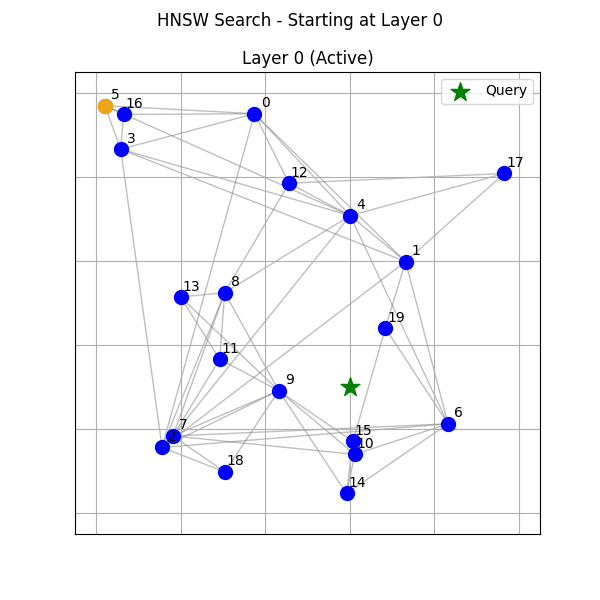

In [ ]:
# Generate a dataset
np.random.seed(42)
num_points = 20
points = np.random.rand(num_points, 2)

# Create an NSW structure
nsw = NSW(
    k=3, # How many connection each point will have in the graph
    ef_construction=10, # The size of the dynamic candidate list during the search process when adding a new point
    random_seed=42
)

# Create an NSW graph
nsw.build_from_points(points)

# Create visualizer
visualizer = HNSWVisualizer(nsw)

# Perform search demo with a query point
query_point = np.array([0.6, 0.3])
nearest_neighbors = visualizer.perform_search_demo(
    query_point,
    k=1, # How many nearest neighbours to retrieve
    ef_search=1, entry_point=5,
    create_animation=True, filename='nsw_search.gif'
)

As you can see, starting from point 5, the algorithm scans each of its neighbours, identifies the one closest to the target point, and moves to it. This procedure is repeated until it reaches a point whose neighbours are all farther from the target.

And here is the example of the situation when we arrive at a non-optimal point:



Search animation saved to nsw_search.gif


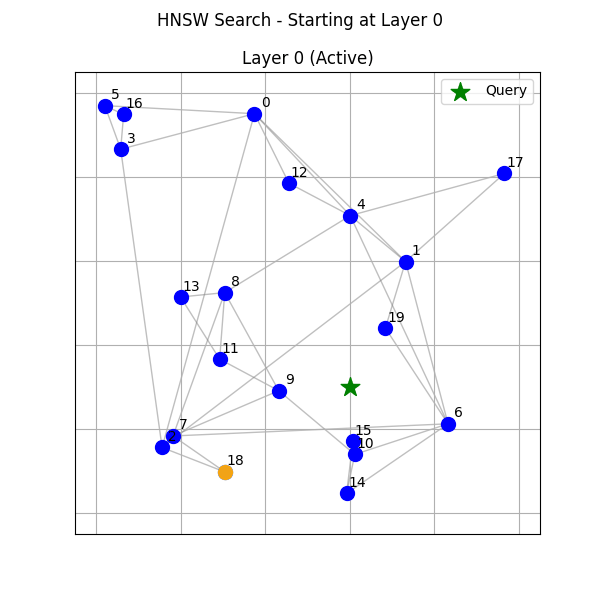

In [ ]:
nsw = NSW(
    k=2, # How many connection each point will have in the graph
    ef_construction=10,
    random_seed=42
)

nsw.build_from_points(points)

visualizer = HNSWVisualizer(nsw)

query_point = np.array([0.6, 0.3])
nearest_neighbors = visualizer.perform_search_demo(
    query_point, k=1, ef_search=1, entry_point=18,
    create_animation=True, filename='nsw_search.gif'
)

Starting from the point 18, we get stuck there.

**NSW construction**

An NSW is constructed in the following way. We add points one by one, each time adding connections to its `k` nearest neighbours, which are usually retrieved using the above procedure in the already built part of the NSW. So, these are approximate nearest neighbours, but that's usually ok.

*An important note*: since each point may further get connected with new points, it can eventually have more than `k` neighbours.

The edges created at the earlier stages, while the graph is sparce, provide global connections, while later edges contribute to finer local geometry.

Let's look at a visualization:

Animation saved to nsw_construction.gif


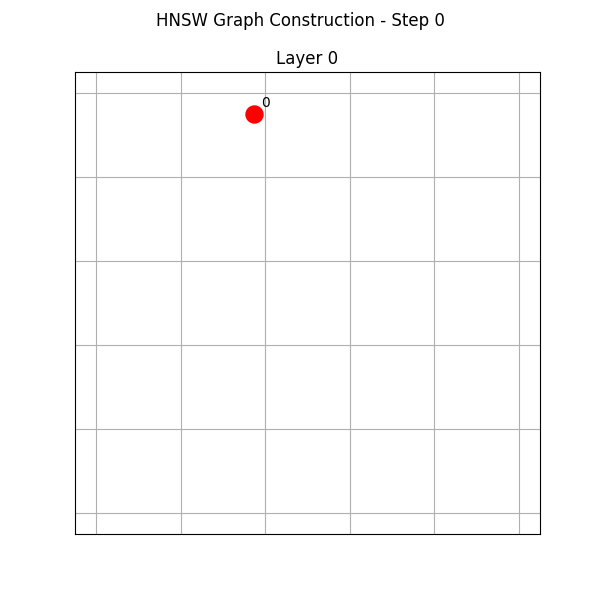

'nsw_construction.gif'

In [ ]:
# Create an NSW structure
nsw = NSW(
    k=3, # How many connection each point will have in the graph
    ef_construction=10, # The size of the dynamic candidate list during the search process when adding a new point
    random_seed=42
)

visualizer = HNSWVisualizer(nsw)

# Perform construction demo with animation
visualizer.perform_construction_demo(
    points=points,
    incremental=True,  # Add points one by one
    filename='nsw_construction.gif',
    fps=1
)

Under mild assumptions, the complexity of search in NSW will be $O(\log^2{N})$, where

* $O(\log{N})$ is the contribution of an average path length,
* Another $O(\log{N})$ is the contribution of an average number of neighbours.

If $N$ is huge, billion-scale, which is typical for web search and recommendation tasks, this is still too much. So, an enhanced version of this algorith is used, called **HNSW**. (Not to be confused with NSFW.)

## Fast Nearest Neighbours search, part 2: Hierarchical Navigable Small World (HNSW)

HNSW creates several layers of NSW graphs:

* The bottom layer contains all the points,
* The higher the layer, the less points there are.

While searching, we first approach the query on the higher, coarse level, then moving down to lower, finer levels.

<center>
<img src="https://drive.google.com/uc?export=view&id=15ZKq_lTchTzlmtn3qrKzBk1XVc71aIFu" width=400 />
</center>

[Source](https://arxiv.org/pdf/1603.09320)

Let's look at a visualization for an HNSW with 3 layers:

Search animation saved to hnsw_search.gif


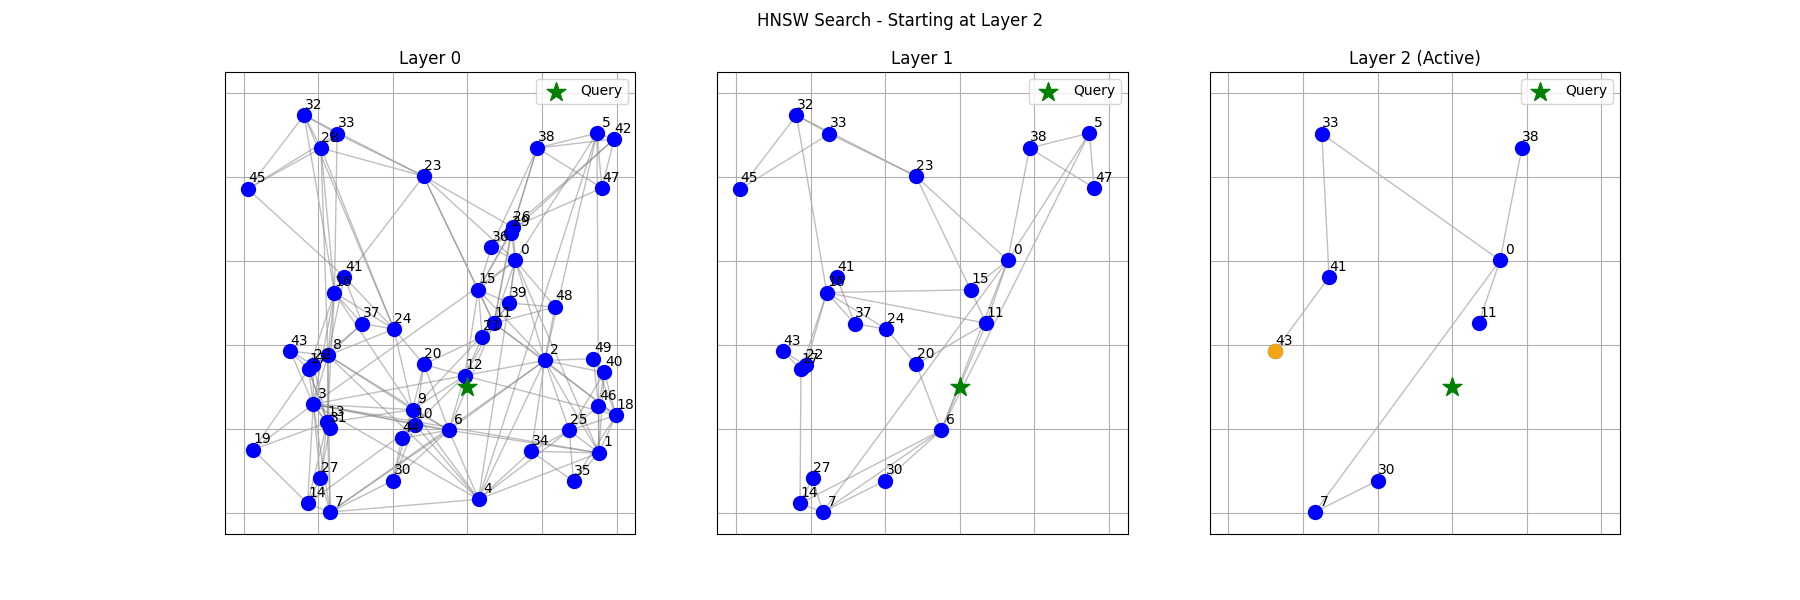

In [ ]:
np.random.seed(36)
num_points = 50
points = np.random.rand(num_points, 2)

# Create HNSW structure with 3 layers
# We'll discuss the parameters in more details below
hnsw = HNSW(
    n_layers=3,
    k_values=[4, 2, 1],
    m_l=1.0,
    ef_construction=10,
    random_seed=42
)

hnsw.build_from_points(points)

visualizer = HNSWVisualizer(hnsw)

# Perform search demo with animation
query_point = np.array([0.6, 0.3])
nearest_neighbors = visualizer.perform_search_demo(
    query_point=query_point,
    k=1, # How many nearest neighbours to retrieve
    ef_search=1, entry_point=43,
    create_animation=True, filename='hnsw_search.gif'
    )

As you see:

- First we try to approach the target point on the top level,
- Then move to the middle one, starting from the closest point from the top level,
- And finally get to the bottom one.

Since the top-level connections are sparse, we can approach the target point faster than we would do in the full graph.

**HNSW construction**

HNSW is constructed by adding points, one by one. Each point is randomly placed on some level: it will appear on this level and all the levels beyond it. The layer index is $\lfloor -\log(\mathrm{U}[0,1])\cdot m_l\rfloor$, where $\mathrm{U}[0,1]$ is the uniform distribution on $[0,1]$ and $m_l$ is a hyperparameter, `m_l` in our implementation. In our implementation the very first point is placed on all levels, though it's not necessary.

Another important hyperparameter is the array `k`: `k[i]` shows how many connections a new point gets with its nearest neighbours on the `i`-th level. In our example `k = [4, 2, 1]`, so that:

- At the bottom layer a point is connected with its 4 neighbours
- At the middle layer - with 2 neighbours
- At the top layer - with 1 neighbours

So, lower layers are not only more densely populated but also more densely connected.

Let's illustrate this:

Animation saved to hnsw_construction.gif


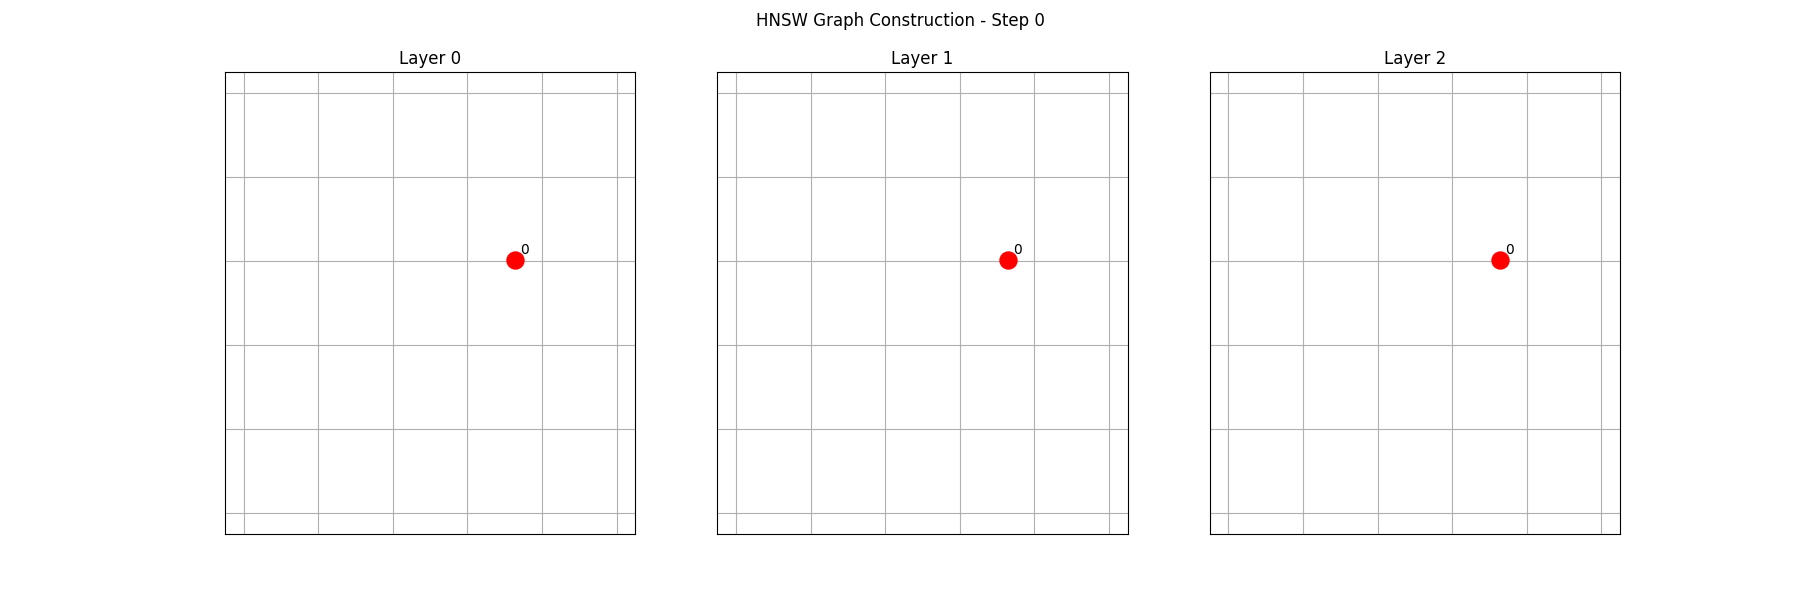

'hnsw_construction.gif'

In [ ]:
np.random.seed(36)
num_points = 50
points = np.random.rand(num_points, 2)

# Create HNSW structure with 3 layers
hnsw = HNSW(
    n_layers=3,
    k_values=[4, 2, 1],
    m_l=1.0,
    ef_construction=10,
    random_seed=42
)

visualizer = HNSWVisualizer(hnsw)

# Perform construction demo
visualizer.perform_construction_demo(
    points=points,
    incremental=True,  # Add points one by one
    filename='hnsw_construction.gif',
    fps=1
)

### Finding several neighbours

In the example above we retrieved only one nearest neighbour. If we need `k`, the algorithm becomes a bit trickier. Namely, we'll maintain

* A priority queue **C** of candidates (min heap by distance)

* A dynamic list **W** of found nearest neighbors (max heap by distance = min heap by negative distance) of length `ef_search`

The parameter`ef_search` should be greater or equal to `k`.

On each step, we:

- pop from **C** the candidate which is the closest to the taget.
  
- If it's further from the target than the closest element of **W** and we have enough elements in **W**, we break the cycle.
  
- Otherwise, all the candidate's neighbours are evaluated, and if some are closer than the current elements of **W** or **W** has yet less than `ef_search` elements, we insert them into both **W** (as a potential nearest neighbout) and into **C** (to check their neighbours).

This algorithm makes search potentially more accurate both inside every layer and at transitions between levels, at which moment points that were further from the target may get surprising new nearest neighbours.

Here's an example for `ef_search = 5`, which means that a dynamic list of 5 potential nearest neighbours is maintained along the way on every layer, and `k = 3`, which means that 3 nearest neighbours will be returned eventually.

Search animation saved to hnsw_search.gif


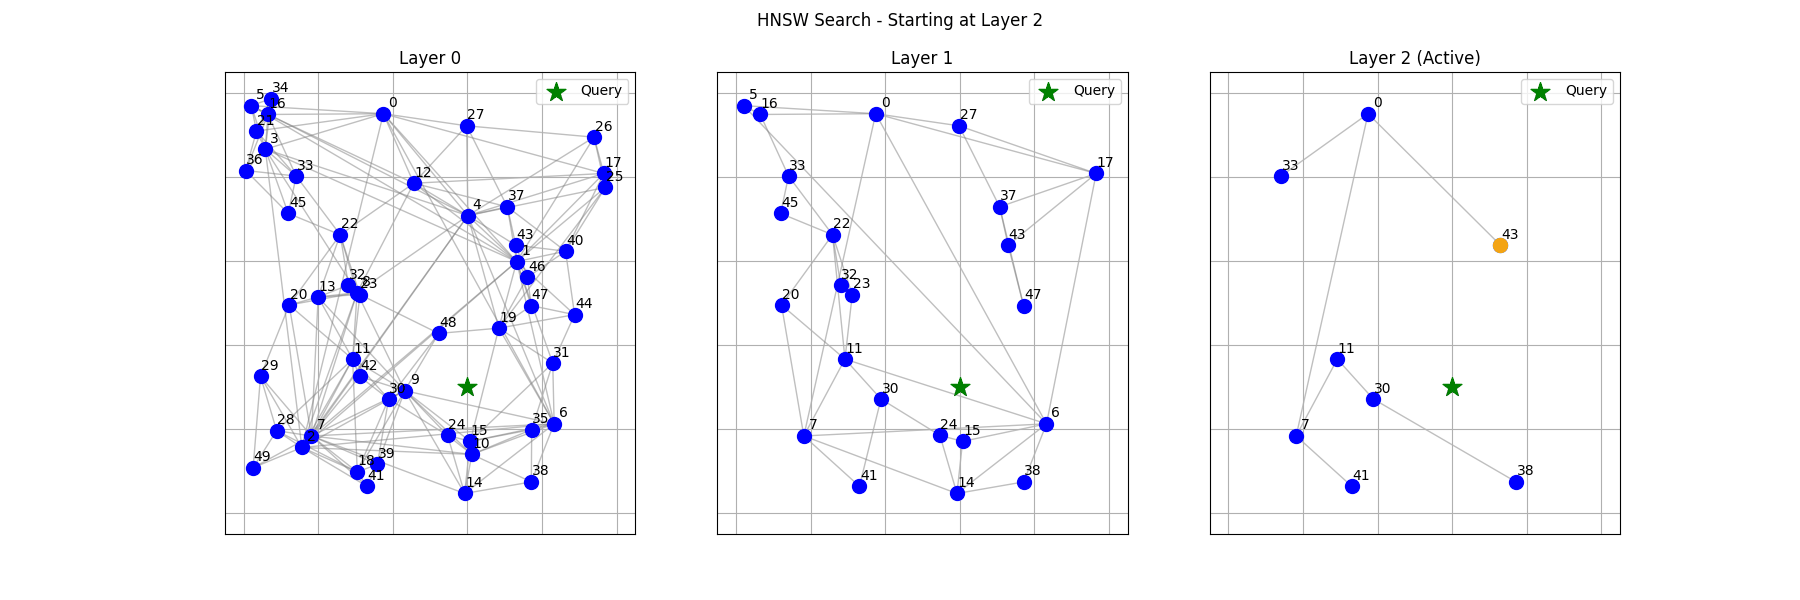

In [ ]:
np.random.seed(42)
num_points = 50
points = np.random.rand(num_points, 2)

# Create HNSW structure with 3 layers
# We'll discuss the parameters in more details below
hnsw = HNSW(
    n_layers=3,
    k_values=[4, 2, 1],
    m_l=1.0,
    ef_construction=10,
    random_seed=42
)

hnsw.build_from_points(points)

visualizer = HNSWVisualizer(hnsw)

# Perform search demo with animation
query_point = np.array([0.6, 0.3])
nearest_neighbors = visualizer.perform_search_demo(
    query_point=query_point,
    k=3, # How many nearest neighbours to retrieve
    ef_search=5, # The size of the dynamic candidate list
    entry_point=43,
    create_animation=True, filename='hnsw_search.gif'
    )

# Practice: Exploring and enhancing RAG pipelines

If you encounter any difficulties or simply want to see our solutions, feel free to check the [Solutions notebook](https://colab.research.google.com/github/Nebius-Academy/LLM-Engineering-Essentials/blob/main/topic3/3.3_advanced_rag_components_solutions.ipynb).

## Task 1. Adding a reranker

In this task, you'll need to add the **reranking stage** to the `answer_with_rag` function.

Compare the results with and without reranking and with different reranking models. Try to come up with tricky and confusing prompts.

In [ ]:
# <YOUR CODE HERE>